# Tips Prediction - Modeling<a id='Tips_Prediction_-_Modeling'></a>

## 1. Contents <a id='1._Contents'></a>
* [Tips Prediction - Modeling](#Tips_Prediction_-_Modeling)
  * [1. Contents](#1._Contents)
  * [2. Sourcing and Loading](#2._Sourcing_and_Loading)
    * [2a. Import relevant libraries](#2a._Import_relevant_libraries)
    * [2b. Load DataFrame](#2b._Load_DataFrame)
  * [3. `tip` model](#3._`tip`_model)
    * [3a. Create bootstrapped DataFrame](#3a._Create_bootstrapped_DataFrame)
    * [3b. Best features for linear regression](#3b._Best_features_for_linear_regression)
    * [3c. Best feature for Random Forest regression](#3c._Best_features_for_Random_Forest_regression)
    * [3d. Model Selection](#3d._Model_Selection)
  * [4. `perc` Model](#4._`perc`_Model)
    * [4a. Best features for linear regression](#4a._Best_features_for_linear_regression)
    * [4b. Best features for Random Forest regression](#4b._Best_features_for_Random_Forest_regression)
    * [4c. Model Selection](#4c._Model_Selection)
  * [5. Model Evaluations](#5._Model_Evaluations)
    * [5a. Evaluation scatterplots](#5a._Evaluation_scatterplots)
    * [5b. R-Squared](#5b._R-Squared)
  * [6. Conclusion and Future Work](#6._Conclusion_and_Future_Work)

## 2. Sourcing and Loading<a id='2._Sourcing_and_Loading'></a>

### 2a. Import relevant libraries<a id='2a._Import_relevant_libraries'></a>

In [237]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import kaggle as kg
import pandas as pd
import missingno as msno
import statsmodels.api as sm
import scipy.stats
from matplotlib.lines import Line2D
from kaggle.api.kaggle_api_extended import KaggleApi
from statsmodels.graphics.api import abline_plot
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, accuracy_score, \
plot_roc_curve, roc_curve, roc_auc_score, precision_recall_curve, auc, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import linear_model, preprocessing
from sklearn.feature_selection import SelectKBest, f_regression
from zipfile import ZipFile
from scipy import stats
from scipy.stats import t
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from numpy.random import seed
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

### 2b. Load DataFrame<a id='2b._Load_DataFrame'></a>

In [3]:
df = pd.read_csv('df.csv', index_col=0)
df.head()

,total_bill,tip,size,perc,sex_Male,smoker_Yes,day_Sat,day_Sun,day_Thur,time_Lunch
0,16.99,1.01,2,5.944673,0,0,0,1,0,0
1,10.34,1.66,3,16.054159,1,0,0,1,0,0
2,21.01,3.50,3,16.658734,1,0,0,1,0,0
3,23.68,3.31,2,13.978041,1,0,0,1,0,0
4,24.59,3.61,4,14.680765,0,0,0,1,0,0


In [49]:
df.shape

(244, 10)

## 3. `tip` Model<a id='3._`tip`_model'></a>

### 3a. Create bootstrapped DataFrame<a id='3a._Create_bootstrapped_DataFrame'></a>

Since our dataset is small, I will construct a new DataFrame and extract 50,000 bootstrapped samples from the original dataset.

In [69]:
randlist = pd.DataFrame(index=np.random.randint(244, size=10000))
boot_df = df.merge(randlist, left_index=True, right_index=True, how='right')
boot_df.reset_index(inplace=True)
boot_df.head()

,index,total_bill,tip,size,perc,sex_Male,smoker_Yes,day_Sat,day_Sun,day_Thur,time_Lunch
0,0,16.99,1.01,2,5.944673,0,0,0,1,0,0
1,0,16.99,1.01,2,5.944673,0,0,0,1,0,0
2,0,16.99,1.01,2,5.944673,0,0,0,1,0,0
3,0,16.99,1.01,2,5.944673,0,0,0,1,0,0
4,0,16.99,1.01,2,5.944673,0,0,0,1,0,0


In [70]:
boot_df.shape

(10000, 11)

### 3b. Best features for linear regression<a id='3b._Best_features_for_linear_regression'></a>

In [139]:
X_cols = [col for col in df.columns if col not in ['tip','perc']]

k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}
lr = LinearRegression()

X = boot_df[X_cols]
y = boot_df['tip']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('simpleimputer',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='median',
                                                      verbose=0)),
                                       ('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('selectkbest',
                                        SelectKBest(k=10,
                                                    score

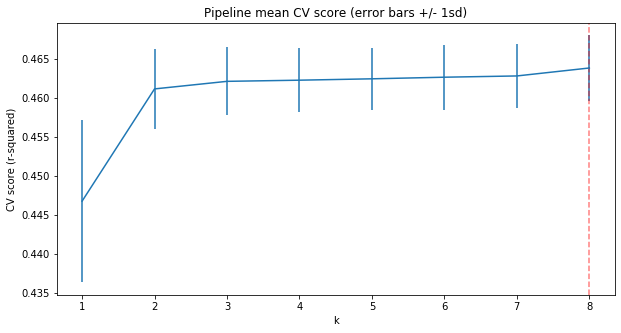

In [140]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [141]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

total_bill    0.803397
size          0.182110
time_Lunch    0.043785
day_Sun      -0.008177
sex_Male     -0.020285
smoker_Yes   -0.048722
day_Sat      -0.060983
day_Thur     -0.088833
dtype: float64

Based on our Grid Search, a linear regression model using `total_bill` and `size` is our most elegant model. Although **8** features results in the strongest model, we can see that there are no significant gains in model strength past 2 features.

### 3c. Best features for Random Forest regression<a id='3c._Best_features_for_Random_Forest_regression'></a>

In [90]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(copy=True, with_mean=True, with_std=True),
  None]}

In [91]:
rf_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestRegressor()
)

X = boot_df[X_cols]
y = boot_df['tip']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rf_grid_cv = GridSearchCV(rf_pipe, param_grid=grid_params, cv=5, n_jobs=-1)
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('simpleimputer',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='median',
                                                      verbose=0)),
                                       ('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('randomforestregressor',
                                        RandomForestRegressor(bootstrap=True,
                           

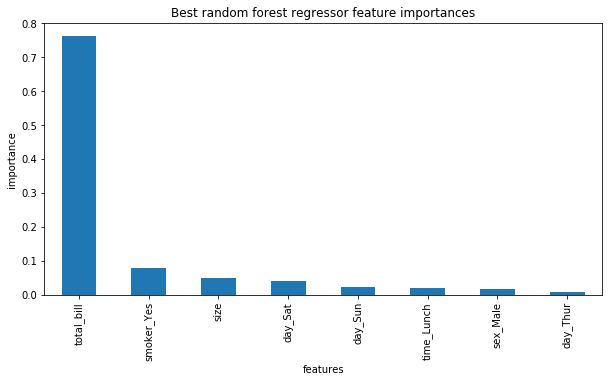

In [92]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

It looks like `total_bill` is the most important feature in our Random Forest regression model.

### 3d. Model selection<a id='3d._Model_Selection'></a>

In [157]:
X = boot_df[X_cols]
y = boot_df['tip']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

(0.7257108188335675, 0.023398043312939903)

In [158]:
mean_absolute_error(y_test, lr.fit(X_train, y_train).predict(X_test))

0.7217191278804096

The mean absolute error for our linear regression model is **~0.72**.

In [186]:
X = boot_df[X_cols]
y = boot_df['tip']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rf_neg_mae = cross_validate(RandomForestRegressor(), X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(1.7659762541200052e-15, 7.460817470488303e-17)

In [187]:
mean_absolute_error(y_test, RandomForestRegressor().fit(X_train, y_train).predict(X_test))

1.831979012933971e-15

The mean absolute error for our Random Forest regression model is **almost zero**, making it a far superior model to the linear regression model. As such, we will go with our Random Forest regression model to predict `tip`.

## 4. `perc` model<a id='4._`perc`_Model'></a>

### 4a. Best features for linear regression<a id='4a._Best_features_for_linear_regression'></a>

In [172]:
X_cols = [col for col in df.columns if col not in ['tip','perc']]

k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}
lr = LinearRegression()

X = boot_df[X_cols]
y = boot_df['perc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('simpleimputer',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='median',
                                                      verbose=0)),
                                       ('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('selectkbest',
                                        SelectKBest(k=10,
                                                    score

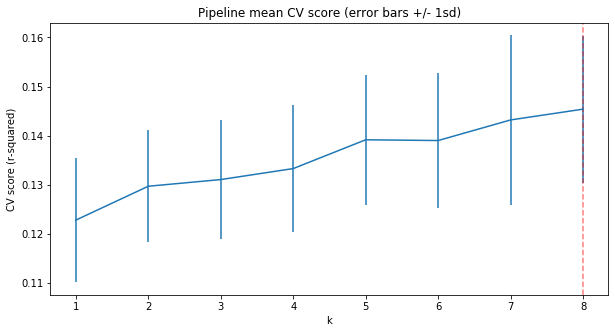

In [173]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [174]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

size          0.609968
day_Sun       0.541279
smoker_Yes    0.463753
time_Lunch    0.347565
day_Sat      -0.156347
sex_Male     -0.233029
day_Thur     -0.449899
total_bill   -2.504552
dtype: float64

It looks like the best linear regression model for `perc` includes every feature.

### 4b. Best features for Random Forest regression<a id='4b._Best_features_for_Random_Forest_regression'></a>

In [145]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(copy=True, with_mean=True, with_std=True),
  None]}

In [147]:
rf_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestRegressor()
)

X = boot_df[X_cols]
y = boot_df['perc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rf_grid_cv = GridSearchCV(rf_pipe, param_grid=grid_params, cv=5, n_jobs=-1)
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('simpleimputer',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='median',
                                                      verbose=0)),
                                       ('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('randomforestregressor',
                                        RandomForestRegressor(bootstrap=True,
                           

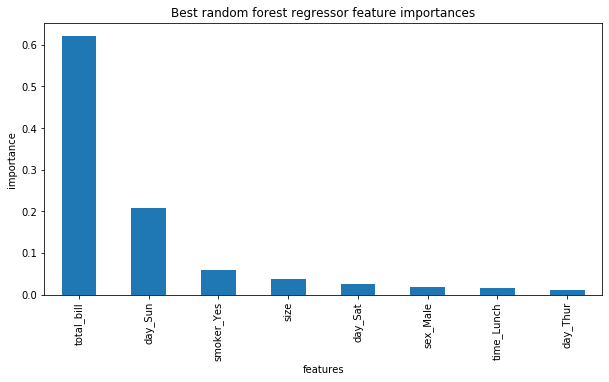

In [148]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

When it comes to our Random Forest regression model, only `total_bill` and `day_Sun` seem to be the most important features.

### 4c. Model Selection<a id='4c._Model_Selection'></a>

In [203]:
X = boot_df[X_cols]
y = boot_df['perc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lr_neg_mae = cross_validate(lr, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

(3.7434888228864915, 0.09618986871259512)

In [204]:
mean_absolute_error(y_test, lr.fit(X_train, y_train).predict(X_test))

3.609983543259733

In [205]:
rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
rmsle

0.44351297254412647

The mean absolute error for our linear regression model is **~3.74**.

In [206]:
X = boot_df[X_cols]
y = boot_df['perc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rf_neg_mae = cross_validate(RandomForestRegressor(), X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(1.8164747483950804e-14, 3.4763463895039586e-16)

In [207]:
mean_absolute_error(y_test, RandomForestRegressor().fit(X_train, y_train).predict(X_test))

1.794520088083118e-14

In [208]:
rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
rmsle

0.44324576494829804

Once again, our Random Forest regression model has a mean absolute error of **almost zero**, so it is the superior model for predicting `perc` as well.

## 5. Model Evaluations<a id='5._Model_Evaluations'></a>

Before conducting numerical evaluations on our models, we can first do a visual evaluation.

### 5a. Evaluation scatterplots<a id='5a._Evaluation_scatterplots'></a>

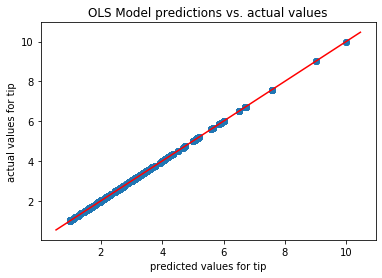

In [189]:
X = boot_df[X_cols]
y = boot_df['tip']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = RandomForestRegressor().fit(X_train, y_train)
y_pred = model.predict(X_test)

_ = plt.scatter(y_test, y_pred)
_ = plt.plot(plt.xlim(), plt.ylim(), color='red')
_ = plt.xlabel('predicted values for tip')
_ = plt.ylabel('actual values for tip')
_ = plt.title('OLS Model predictions vs. actual values')

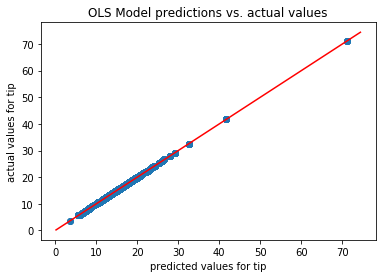

In [191]:
X = boot_df[X_cols]
y = boot_df['perc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = RandomForestRegressor().fit(X_train, y_train)
y_pred = model.predict(X_test)

_ = plt.scatter(y_test, y_pred)
_ = plt.plot(plt.xlim(), plt.ylim(), color='red')
_ = plt.xlabel('predicted values for perc')
_ = plt.ylabel('actual values for perc')
_ = plt.title('OLS Model predictions vs. actual values')

Visually, it looks like our 2 models for `tip` and `perc` are very strong. The predicted and actual values are almost on a straight line.

### 5b. R-Squared<a id='5b._R-Squared'></a>

In [224]:
X = boot_df[X_cols]
y = boot_df['tip']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = RandomForestRegressor().fit(X_train, y_train)
model.fit(X_train, y_train)
model.score(X_test, y_test)

1.0

In [218]:
X = boot_df[X_cols]
y = boot_df['perc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = RandomForestRegressor().fit(X_train, y_train)
model.fit(X_train, y_train)
model.score(X_test, y_test)

1.0

Our 2 Random Forest regression models have an $R^{2}$ of 1.0, denoting a perfect correlation between actual values and predicted values. 

# 6. Conclusion and Future Work<a id='6._Conclusion_and_Future_Work'></a>

After bootstrapping a large number of samples from our original dataset, I was able to fit a predictive model to predict `tip` and `perc` amounts using a Random Forest regression model. Both of my models have $R^{2}$ values of 1.0, putting them at near **100% accuracy**. 

It is possible that achieving 100% accuracy was made easier by bootstrapping such a small sample. In order for future predictive models to stay accurate, more data should be collected. Furthermore, this model only applies to this particular server at their particular restaurant. This data is most likely not generalizable to all restaurants, meaning other restaurants will most likely have to gather their own data. 

However, it will be encouraging for those establishments to know that an accurate model can be used to predict tips using basic information that can be easily gathered, instead of requiring qualitative data like customer service quality or customer rating of food. Such data would require a lot more work to gather. 